In [52]:
%pylab inline
import cv2 as cv
import open3d as o3d
from typing import Union, Any
import glob, re
import os
import sys
from zipfile import ZipFile
from configparser import ConfigParser
from io import BytesIO
from PIL import Image
from skimage.util import random_noise
plt.rcParams["figure.figsize"] = (40,40)

Populating the interactive namespace from numpy and matplotlib


In [13]:
source_file = './source files/Prusa_SL1_Calibration_test_2H_40M_50um_Prusa_Orange.sl1'
zip_file = ZipFile(source_file)

In [14]:
# not working (invalid ini file, need sections to be valid)
config = ConfigParser()
config.read(zip_file.read('config.ini'))

[]

### Get config

In [15]:
def duck_cast(value: str) -> Union[int, float]:
    "Cast value to int or float."
    try:
        return int(value)
    except ValueError:
        return float(value)

def load_config(data: bytes) -> dict:
    peaces = [ p.split('=', maxsplit=1) for p in data.decode().strip().split('\n')]
    # Don't trust invalid ini file expecting space and characters inconsistency
    # Simple faster way
    # return {v[0].strip(): v[1].strip() for v in config if len(v) > 1}
    config = {}
    for v in peaces:
        if len(v) > 1:
            try:
                config[v[0].strip()] = duck_cast(v[1])
            except ValueError:
                config[v[0].strip()] = v[1].strip()
    return config
                
    

config = load_config(zip_file.read('config.ini'))
slicer = load_config(zip_file.read('prusaslicer.ini'))
# {'config': config, 'slicer': slicer}

In [5]:
# let see how slow it is
# with casting: 141 µs ± 1.81 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
# without: 53.5 µs ± 85.9 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
# ... good enaugh
%timeit load_config(zip_file.read('prusaslicer.ini'))

141 µs ± 330 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


### Get images

In [16]:
# %%timeit
images = {}
for f in zip_file.filelist:
    if config['jobDir'] in f.filename:
        # not used but usefull
        info = re.match(f"{config['jobDir']}(.+)\.(.+)", f.filename)
        if hasattr(info, 'groups'):
            arr = np.frombuffer(zip_file.read(f.filename),np.uint8)
            images[f.filename] = cv.imdecode(arr, cv.IMREAD_GRAYSCALE)
# images

In [129]:
def normalize_contour(contour: array) -> array:
    x = slicer['display_pixels_x']
    y = slicer['display_pixels_y']
    h = slicer['display_height']
    w = slicer['display_width']
    return np.array([[[p[0][0]/x*w, p[0][1]/y*h]] for p in contour])

def make_shitty_point_cloud(images: dict, transform_func=None, func_args=()) -> array:
    point_cloud = []
    height = config['layerHeight']
    for h,i in enumerate(images.values()):
        # drop junk
        i[i > 0] = 255
        new = np.full(i.shape, 0, np.uint8)
        if transform_func is not None:
            new = transform_func(i,new, *func_args)
            contours, _ = cv.findContours(new, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
        else:
            contours, _ = cv.findContours(i, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
        for c in contours:
            c = normalize_contour(c)
            for p in c:
                point_cloud.append([p[0][0], p[0][1], height*h])
    return np.array(point_cloud)

def make_edited_images(images: dict, transform_func=None, func_args=()) -> dict:
    new_images = {}
    for h,(k,i) in enumerate(images.items()):
        # drop junk
        i[i > 0] = 255
        new = np.full(i.shape, 0, np.uint8)
        if transform_func is not None:
            new = transform_func(img, new, *func_args)
        new_images[k] = cv.imencode('.png', new)[1]
    return new_images

def save_sl1(source:str, destination:str, images: dict)->None:
    try:
        os.remove(destination)
    except FileNotFoundError:
        pass
    with ZipFile(destination, 'w') as dest:
        for n,i in images.items():
            dest.writestr(n,i)
        with ZipFile(source, 'r') as src:
            for fn in src.filelist:
                if not fn.filename in dest.namelist():
                    dest.writestr(fn.filename, src.read(fn.filename))
        

## 3D not aware transformations

In [156]:
img = list(images.values())[201]

### simplify edges
Open CV arc detector and simplifier. Can be used but wery unstable results. 

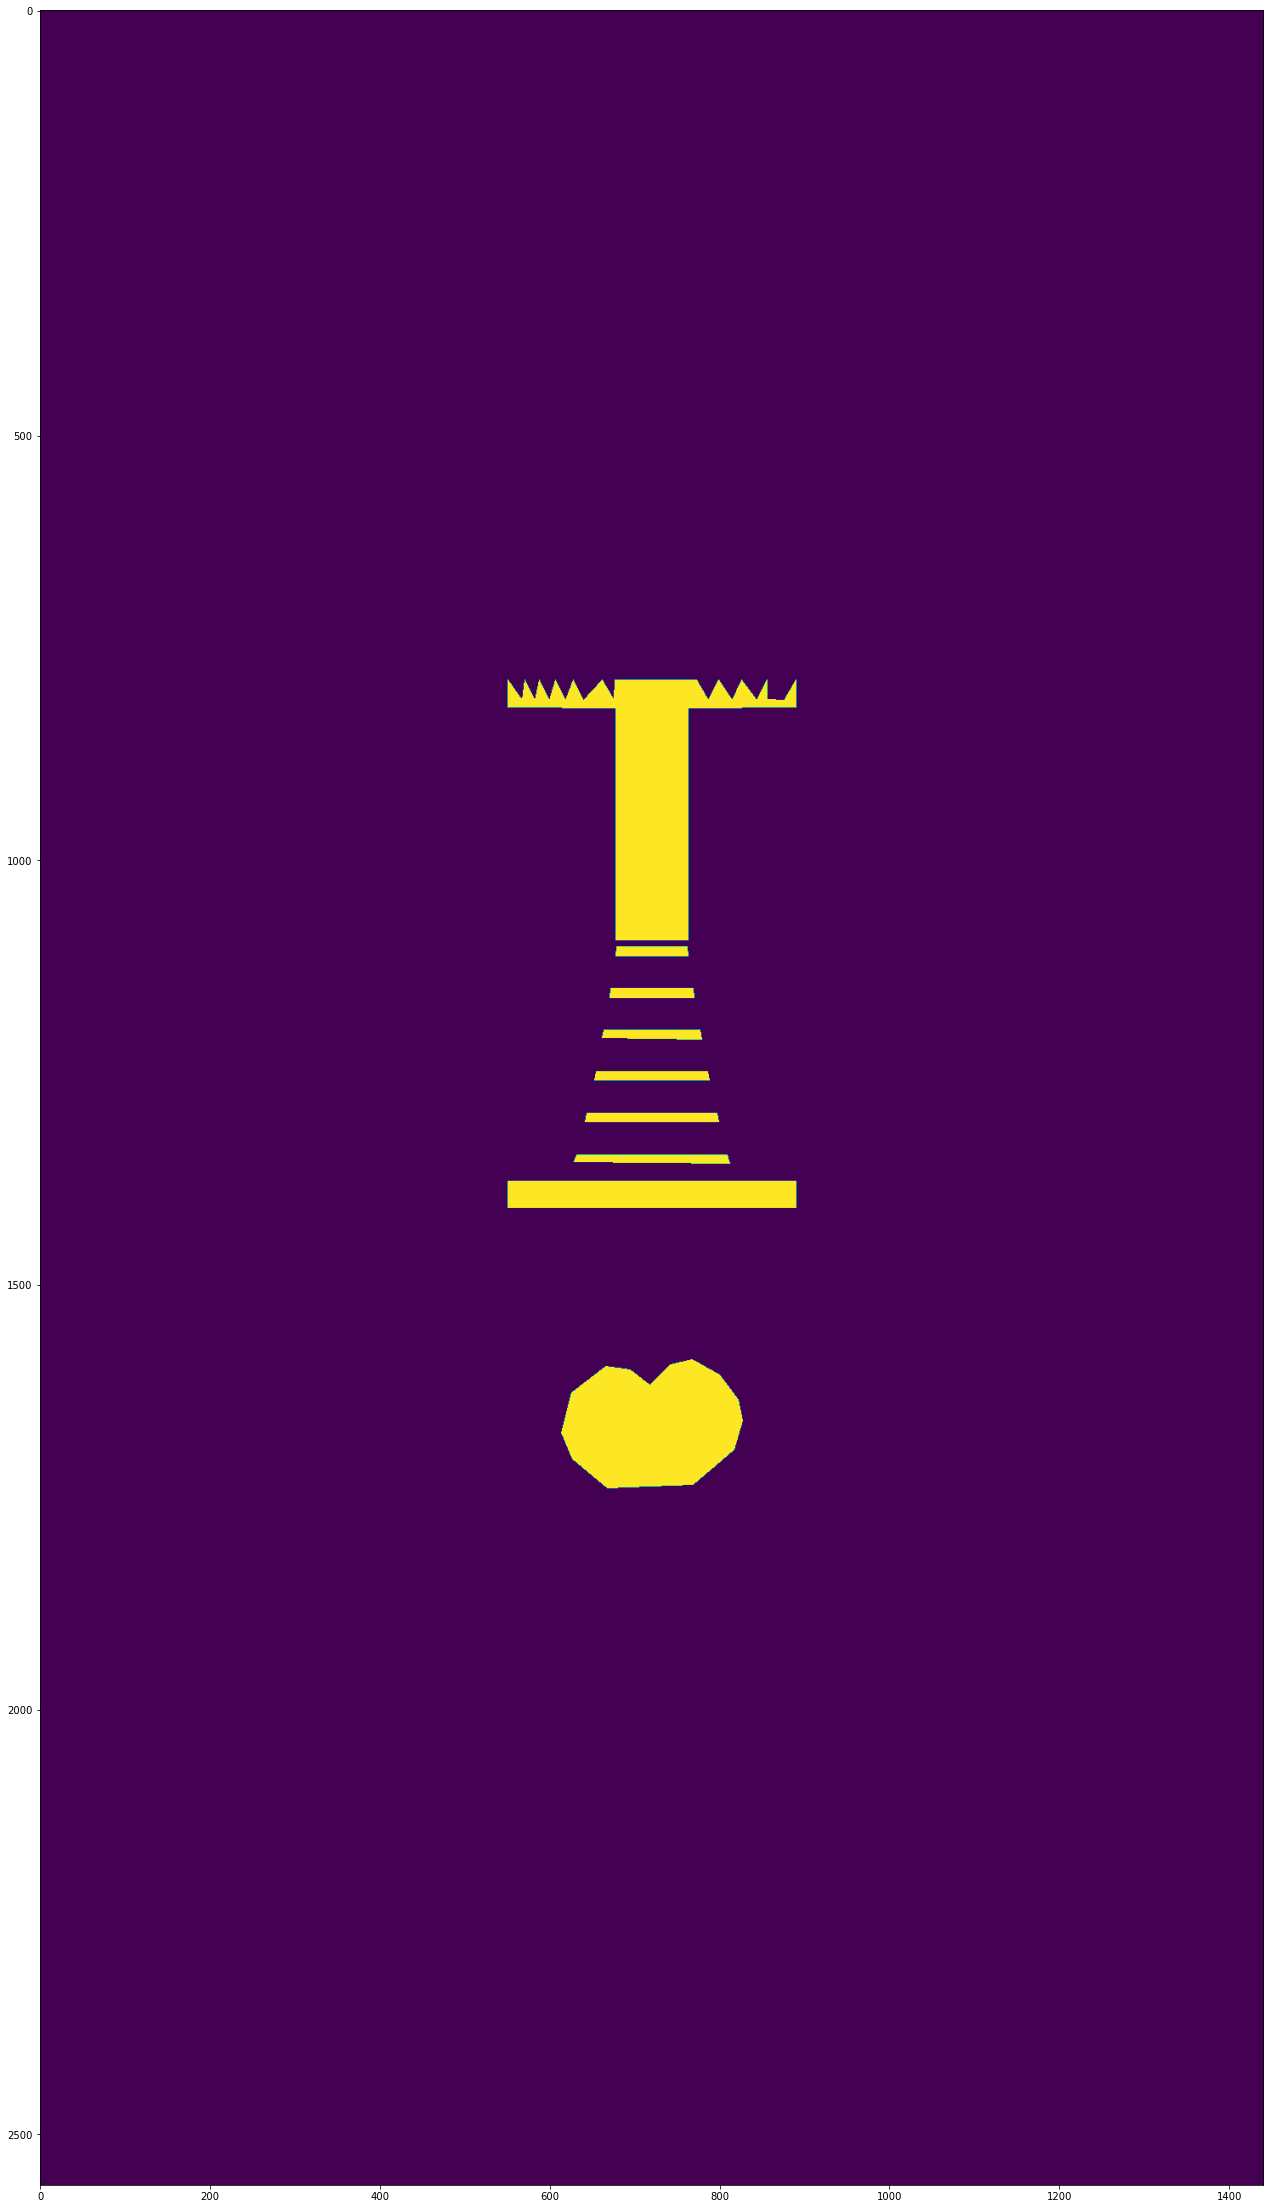

In [53]:
def simplify(img, new, amount=0.005):
    approx = []
    contours, _ = cv.findContours(img, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
    for c in contours:
        e = amount*cv.arcLength(c, True)
        approx.append(cv.approxPolyDP(c, e, True))
    return cv.drawContours(new, approx, -1, 255, -1)

# drop junk
img[img > 0] = 255
new = np.full(img.shape, 0, np.uint8)
imshow(simplify(img, new, 0.008))

In [58]:
cloud = make_shitty_point_cloud(images, simplify, (0.01,))
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(cloud)
pcd.estimate_normals()
o3d.visualization.draw_geometries([pcd])

In [88]:
edited = make_edited_images(images, simplify, (0.01,))
save_sl1(source_file, 'simplyfied.sl1', edited)

### Rectanglefy

Take all countours and replace them with boundig boxes. (Could be fun to see, but probably supports are needed)

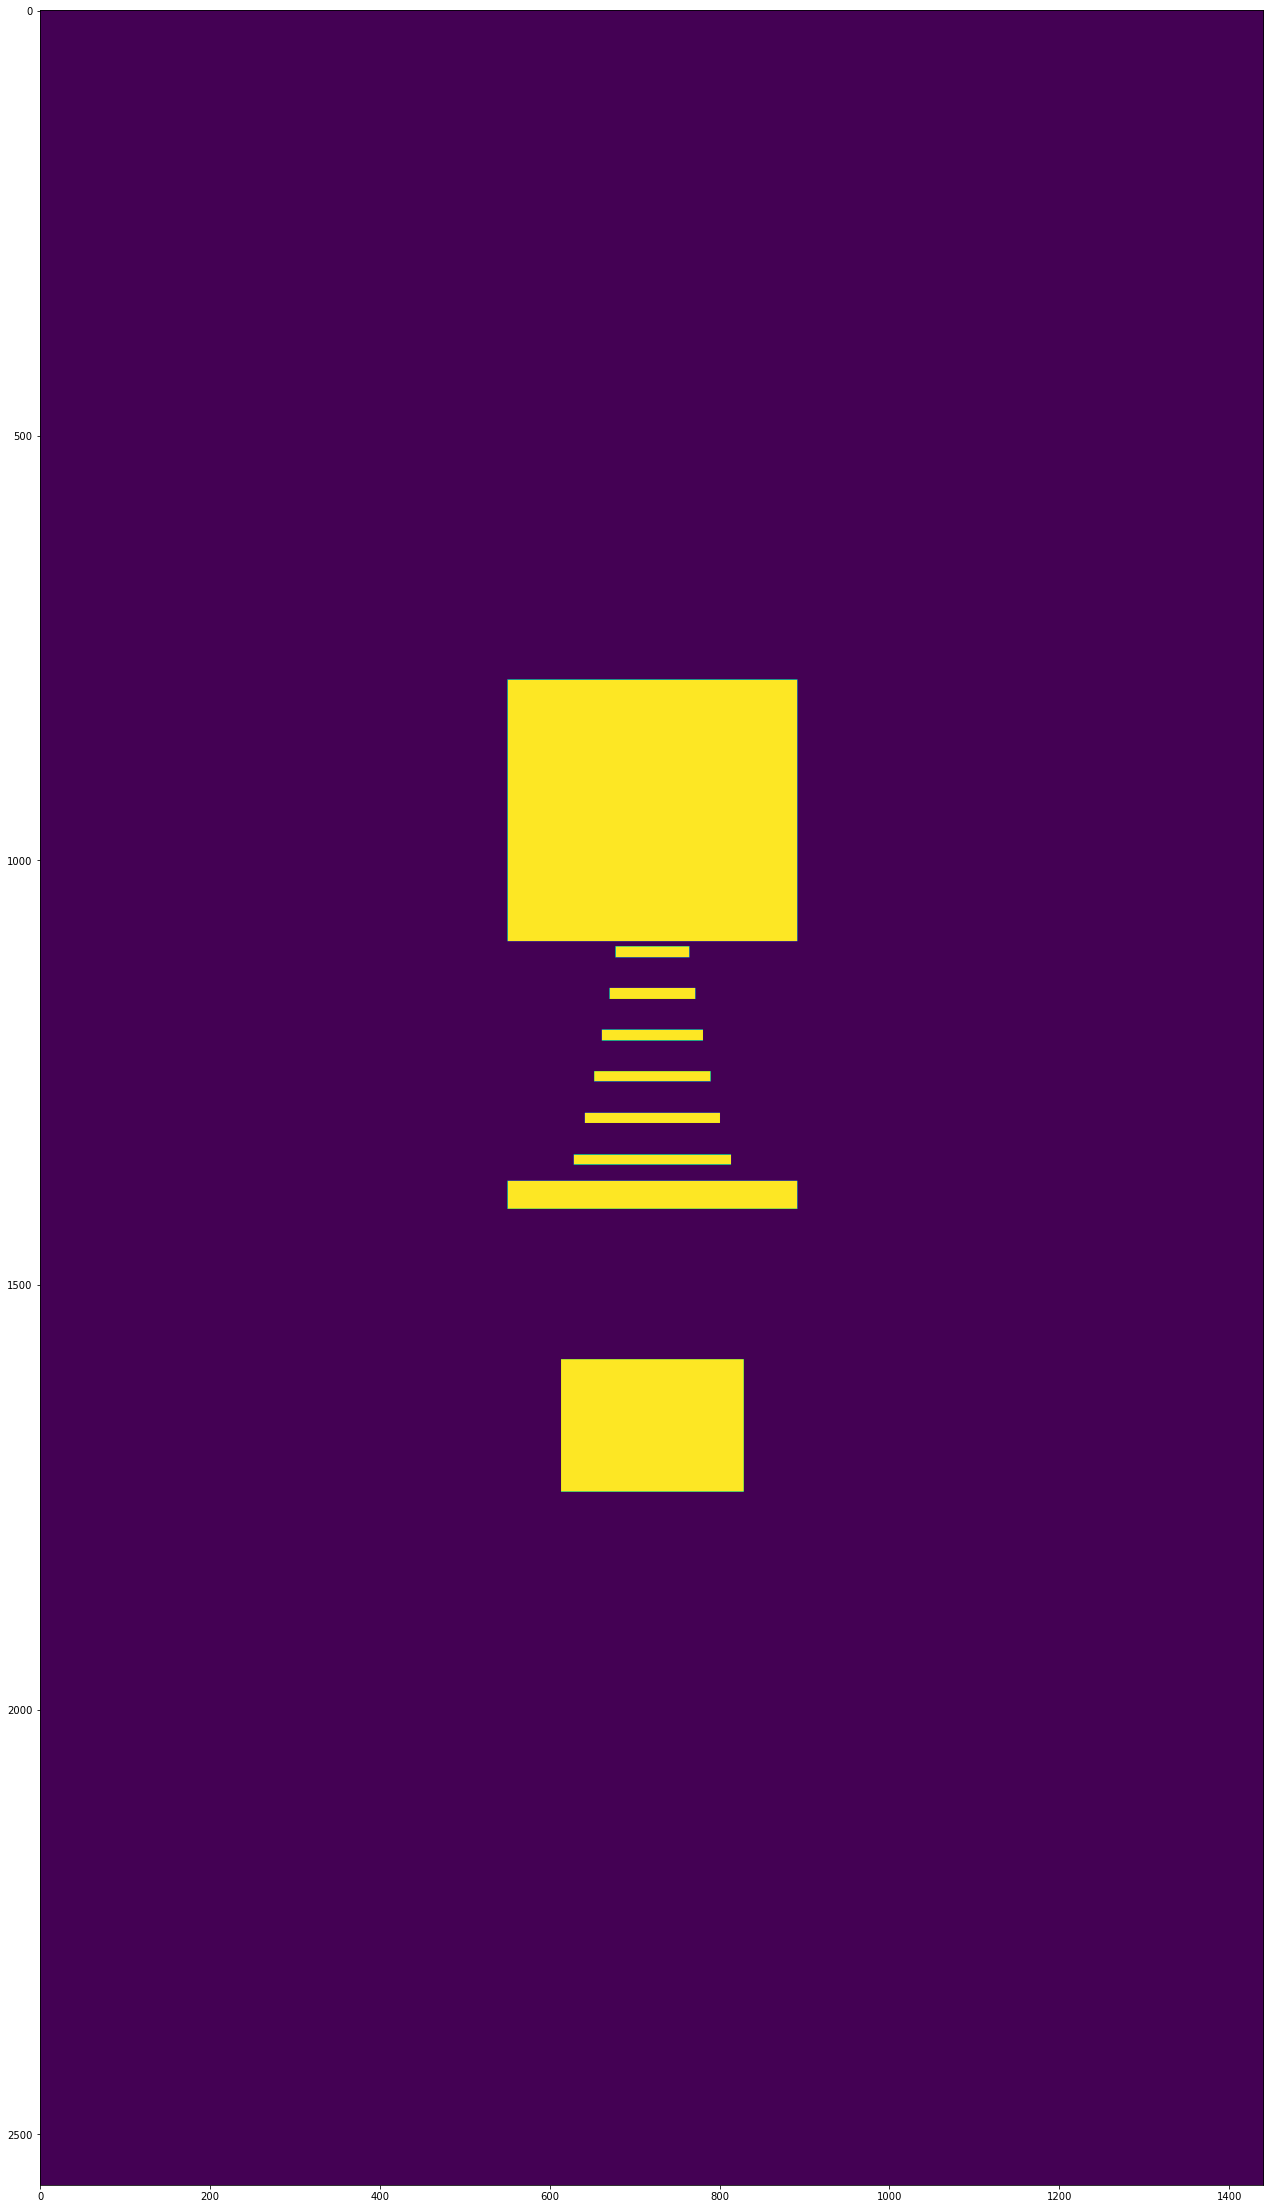

In [54]:
def rectanglefy(img, new):
    approx = []
    contours, _ = cv.findContours(img, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
    for c in contours:
        x, y, w, h = cv.boundingRect(c)
        approx.append(np.array([[[x,y], [x,y+h], [x+w,y+h], [x+w,y]]]))
    return cv.drawContours(new, approx, -1, 255, -1)

# drop junk
img[img > 0] = 255
new = np.full(img.shape, 0, np.uint8)
imshow(rectanglefy(img, new))

In [ ]:
cloud = make_shitty_point_cloud(images, rectanglefy)
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(cloud)
pcd.estimate_normals()
o3d.visualization.draw_geometries([pcd])

In [89]:
edited = make_edited_images(images, rectanglefy)
save_sl1(source_file, 'rectanglefied.sl1', edited)

### Smooth
Using erode and than dilatate to "simplify" contours on the layer. 

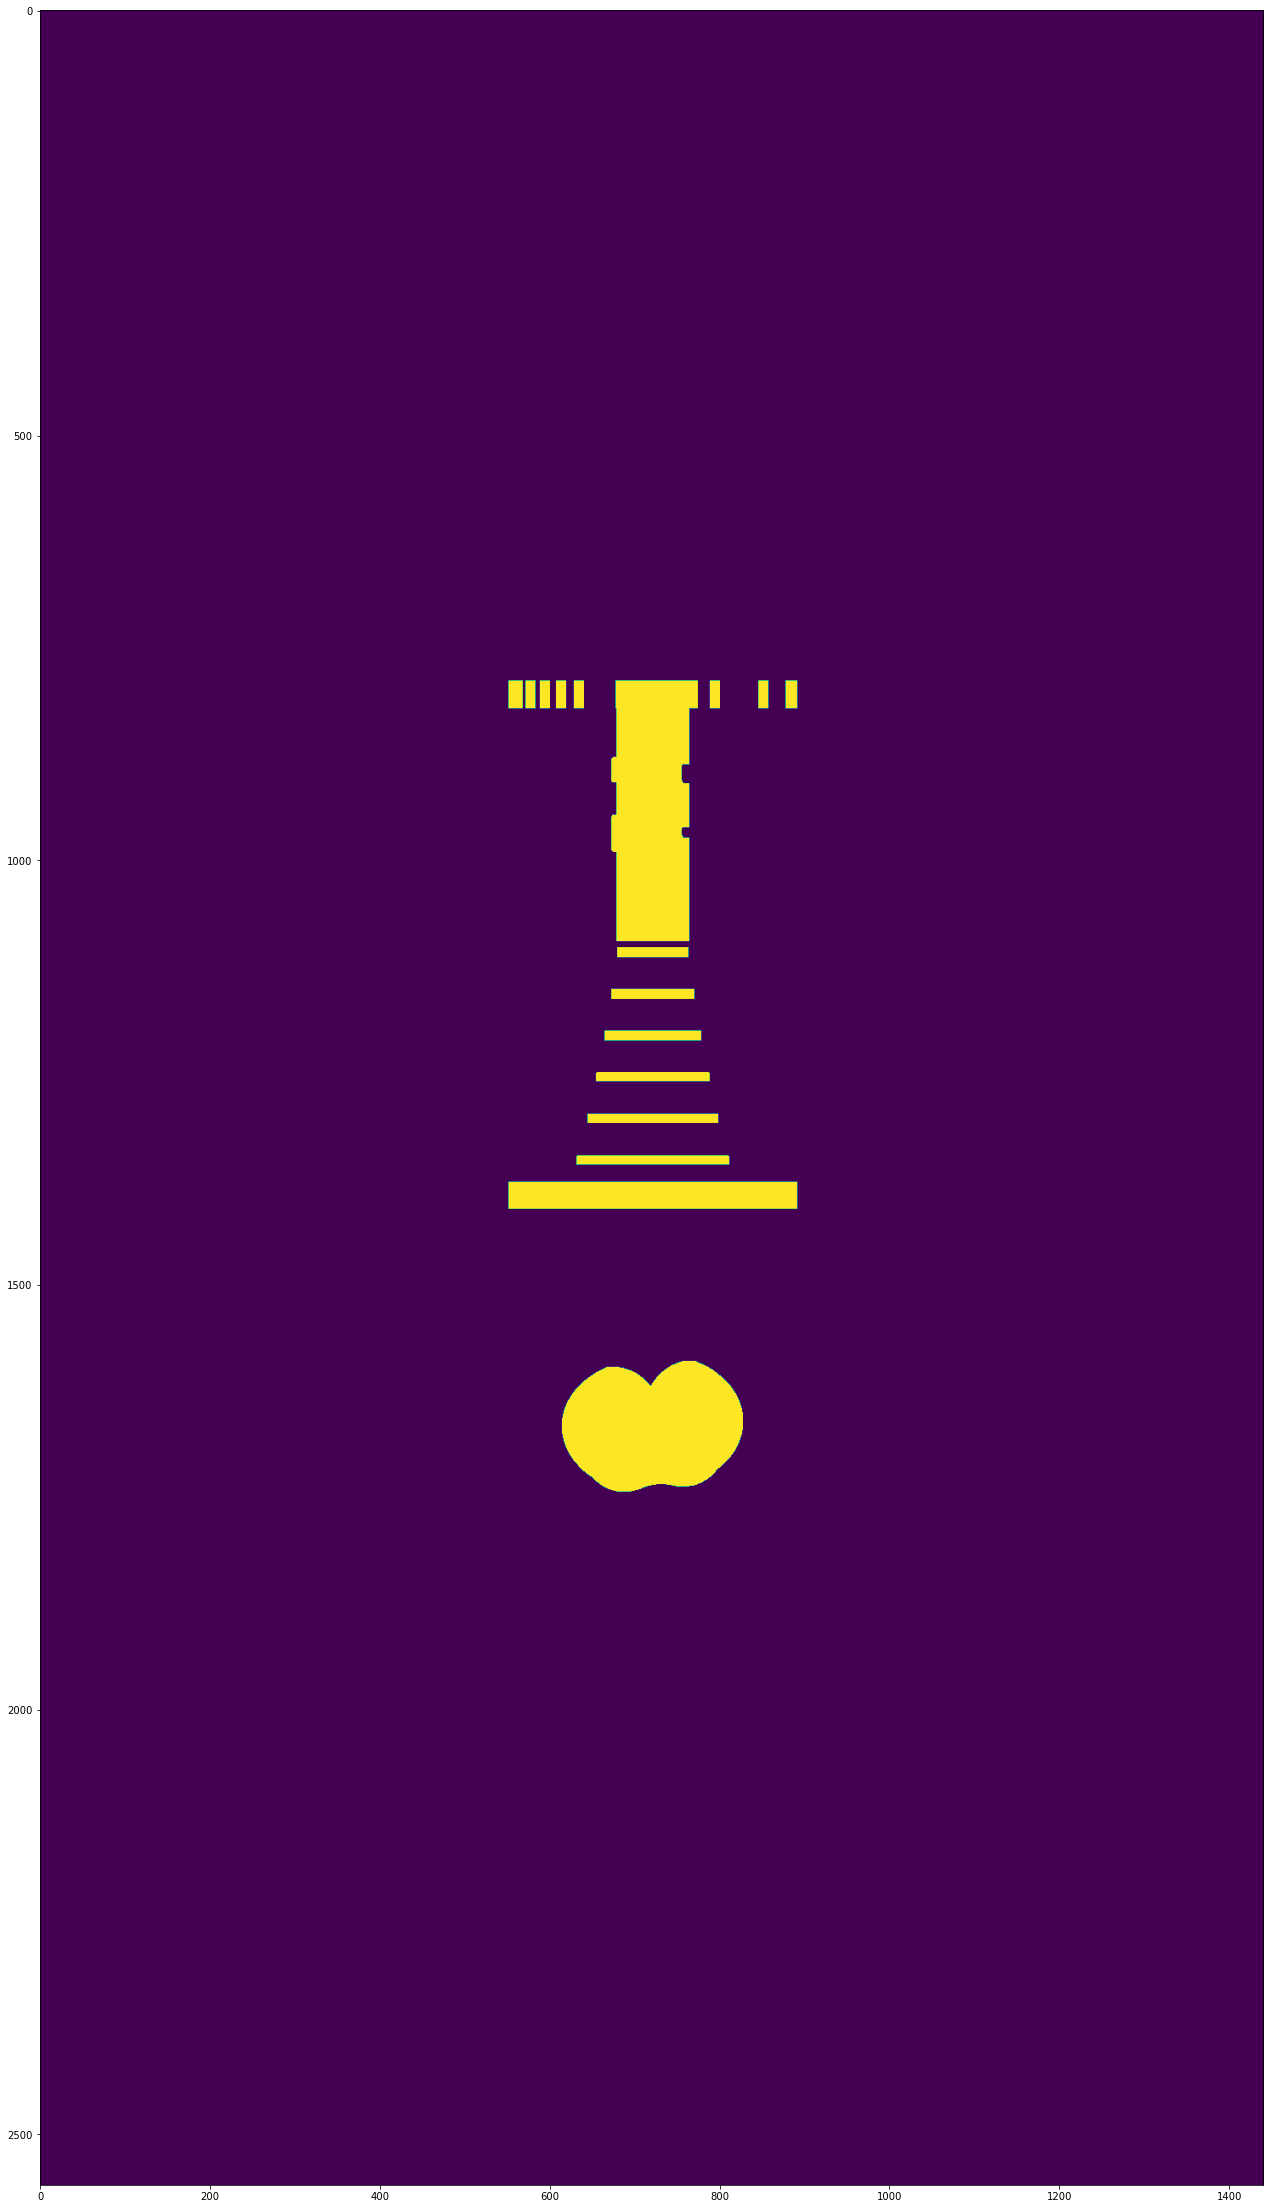

In [55]:
def smooth(img, new, kernel=(5,5), iterations=1):
    kernel = np.ones(kernel, np.uint8)
    new = cv.erode(img, kernel, iterations = iterations)
    new = cv.dilate(new, kernel, iterations = iterations)
    return new

# drop junk
img[img > 0] = 255
new = np.full(img.shape, 0, np.uint8)
imshow(smooth(img, new, kernel=(10,12)))

In [ ]:
cloud = make_shitty_point_cloud(images, smooth,((10,12),))
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(cloud)
pcd.estimate_normals()
o3d.visualization.draw_geometries([pcd])

In [90]:
edited = make_edited_images(images, smooth,((10,12),))
save_sl1(source_file, 'smoothed.sl1', edited)

### Gauss blurr smoothing
Basicaly making Gauss blur than floor the stuff to 0 or 255.  

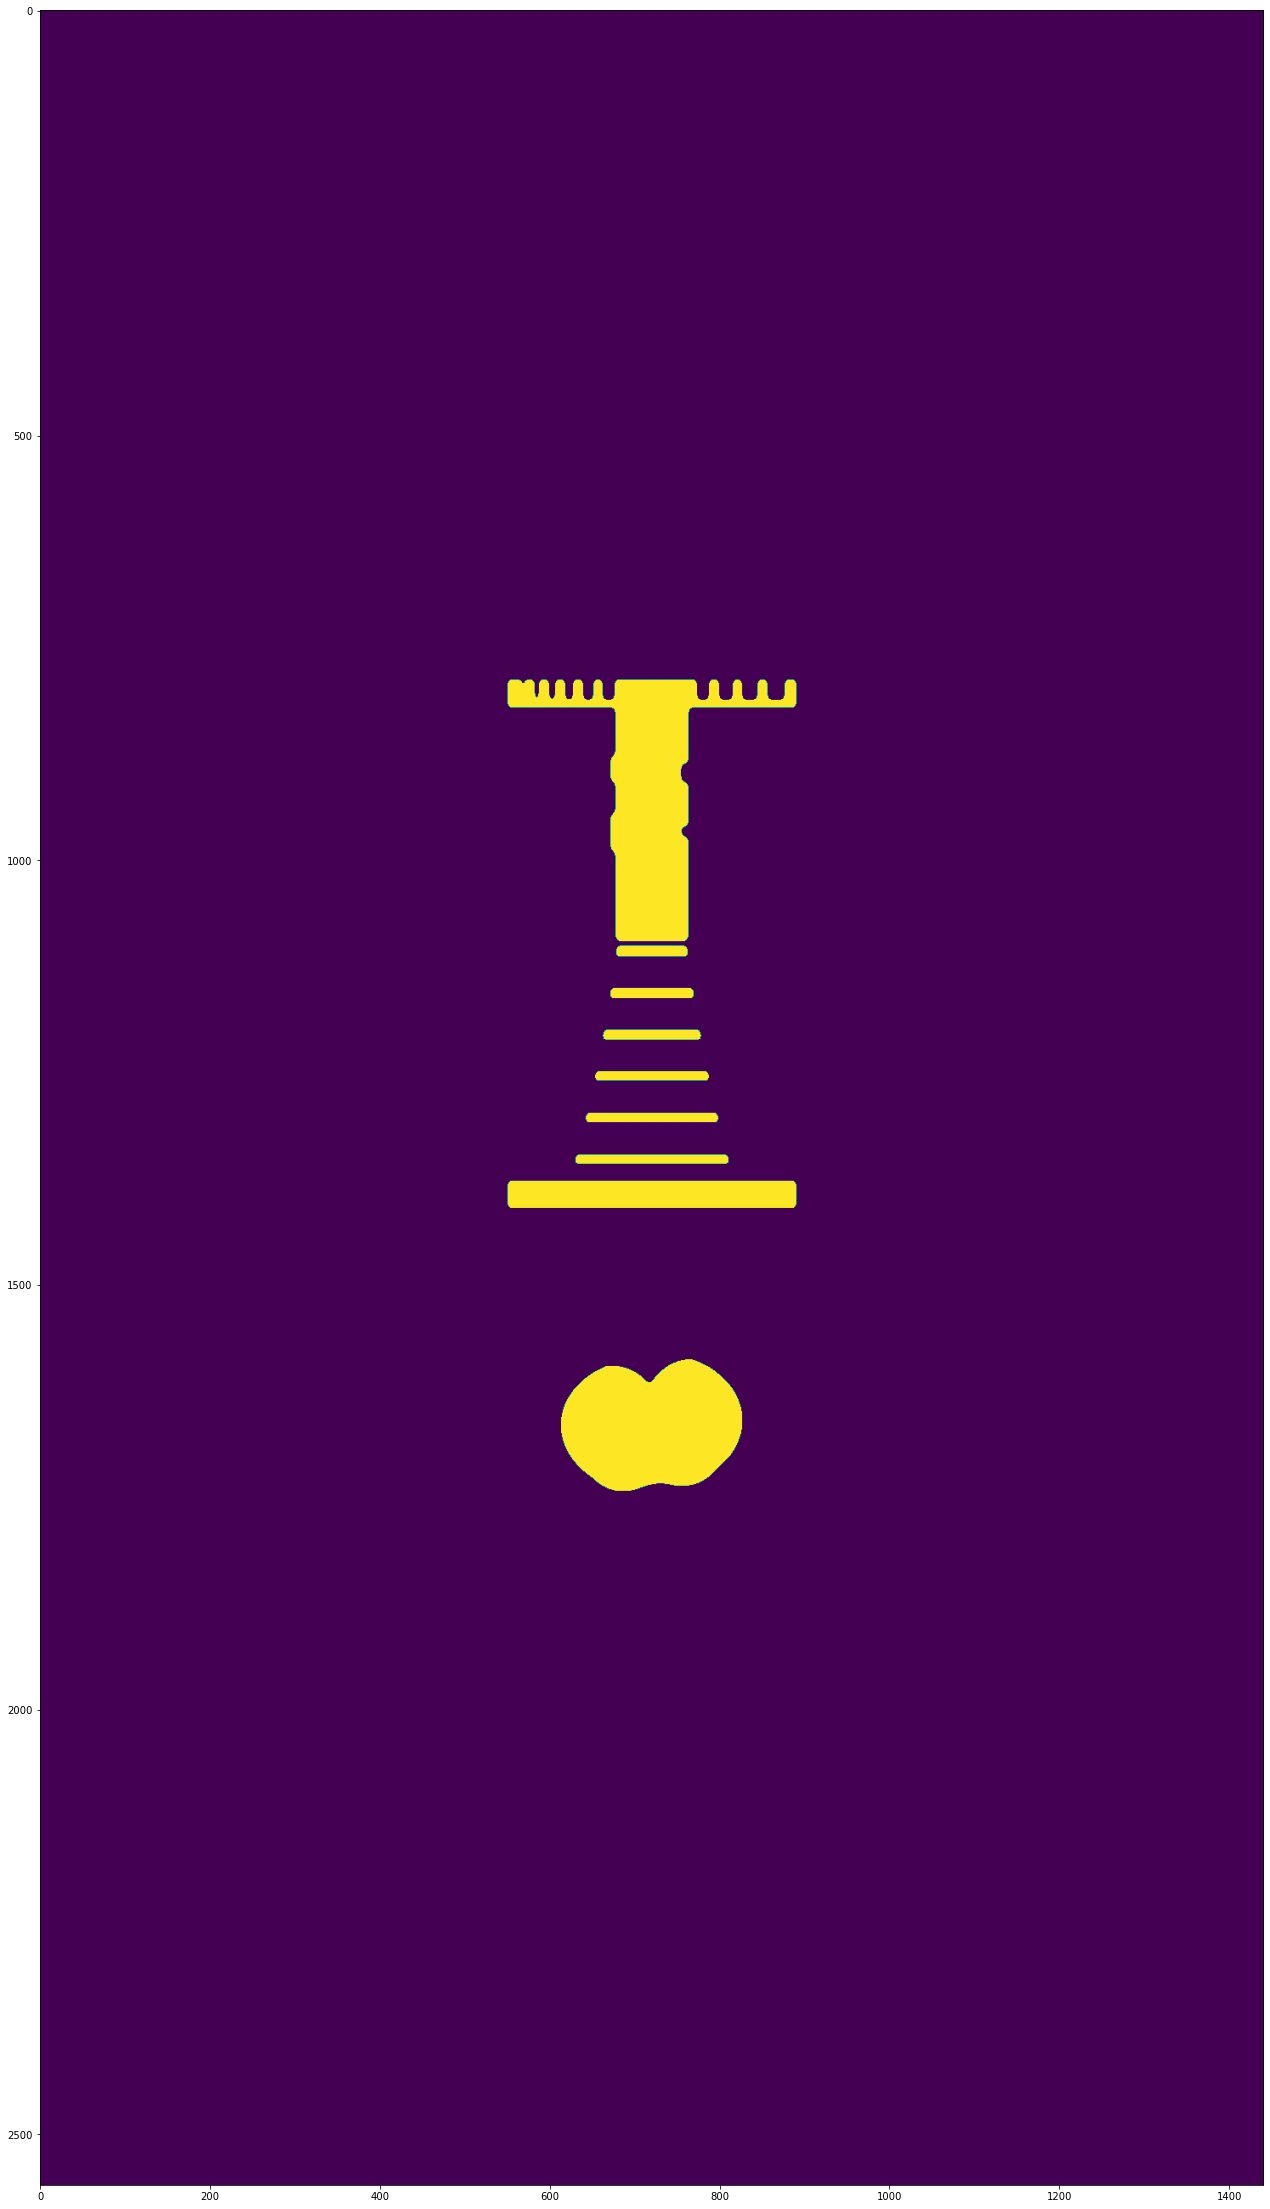

In [56]:
def gauss_smooth(img, new, kernel=(5,5), sigma = 1):
    new = cv.GaussianBlur(img, kernel,sigma)
    new[new > 122] = 255
    new[new < 122] = 0
    return new

# drop junk
img[img > 0] = 255
new = np.full(img.shape, 0, np.uint8)
imshow(gauss_smooth(img, new, (15,25),0))

In [125]:
cloud = make_shitty_point_cloud(images, gauss_smooth,((15,25),5))
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(cloud)
pcd.estimate_normals()
o3d.visualization.draw_geometries([pcd])

In [133]:
edited = make_edited_images(images, gauss_smooth,((15,25),5))
save_sl1(source_file, 'gaussed.sl1', edited)

### Mess up edges
Add Gaussian noise to edges of the layer. (What they asked for)

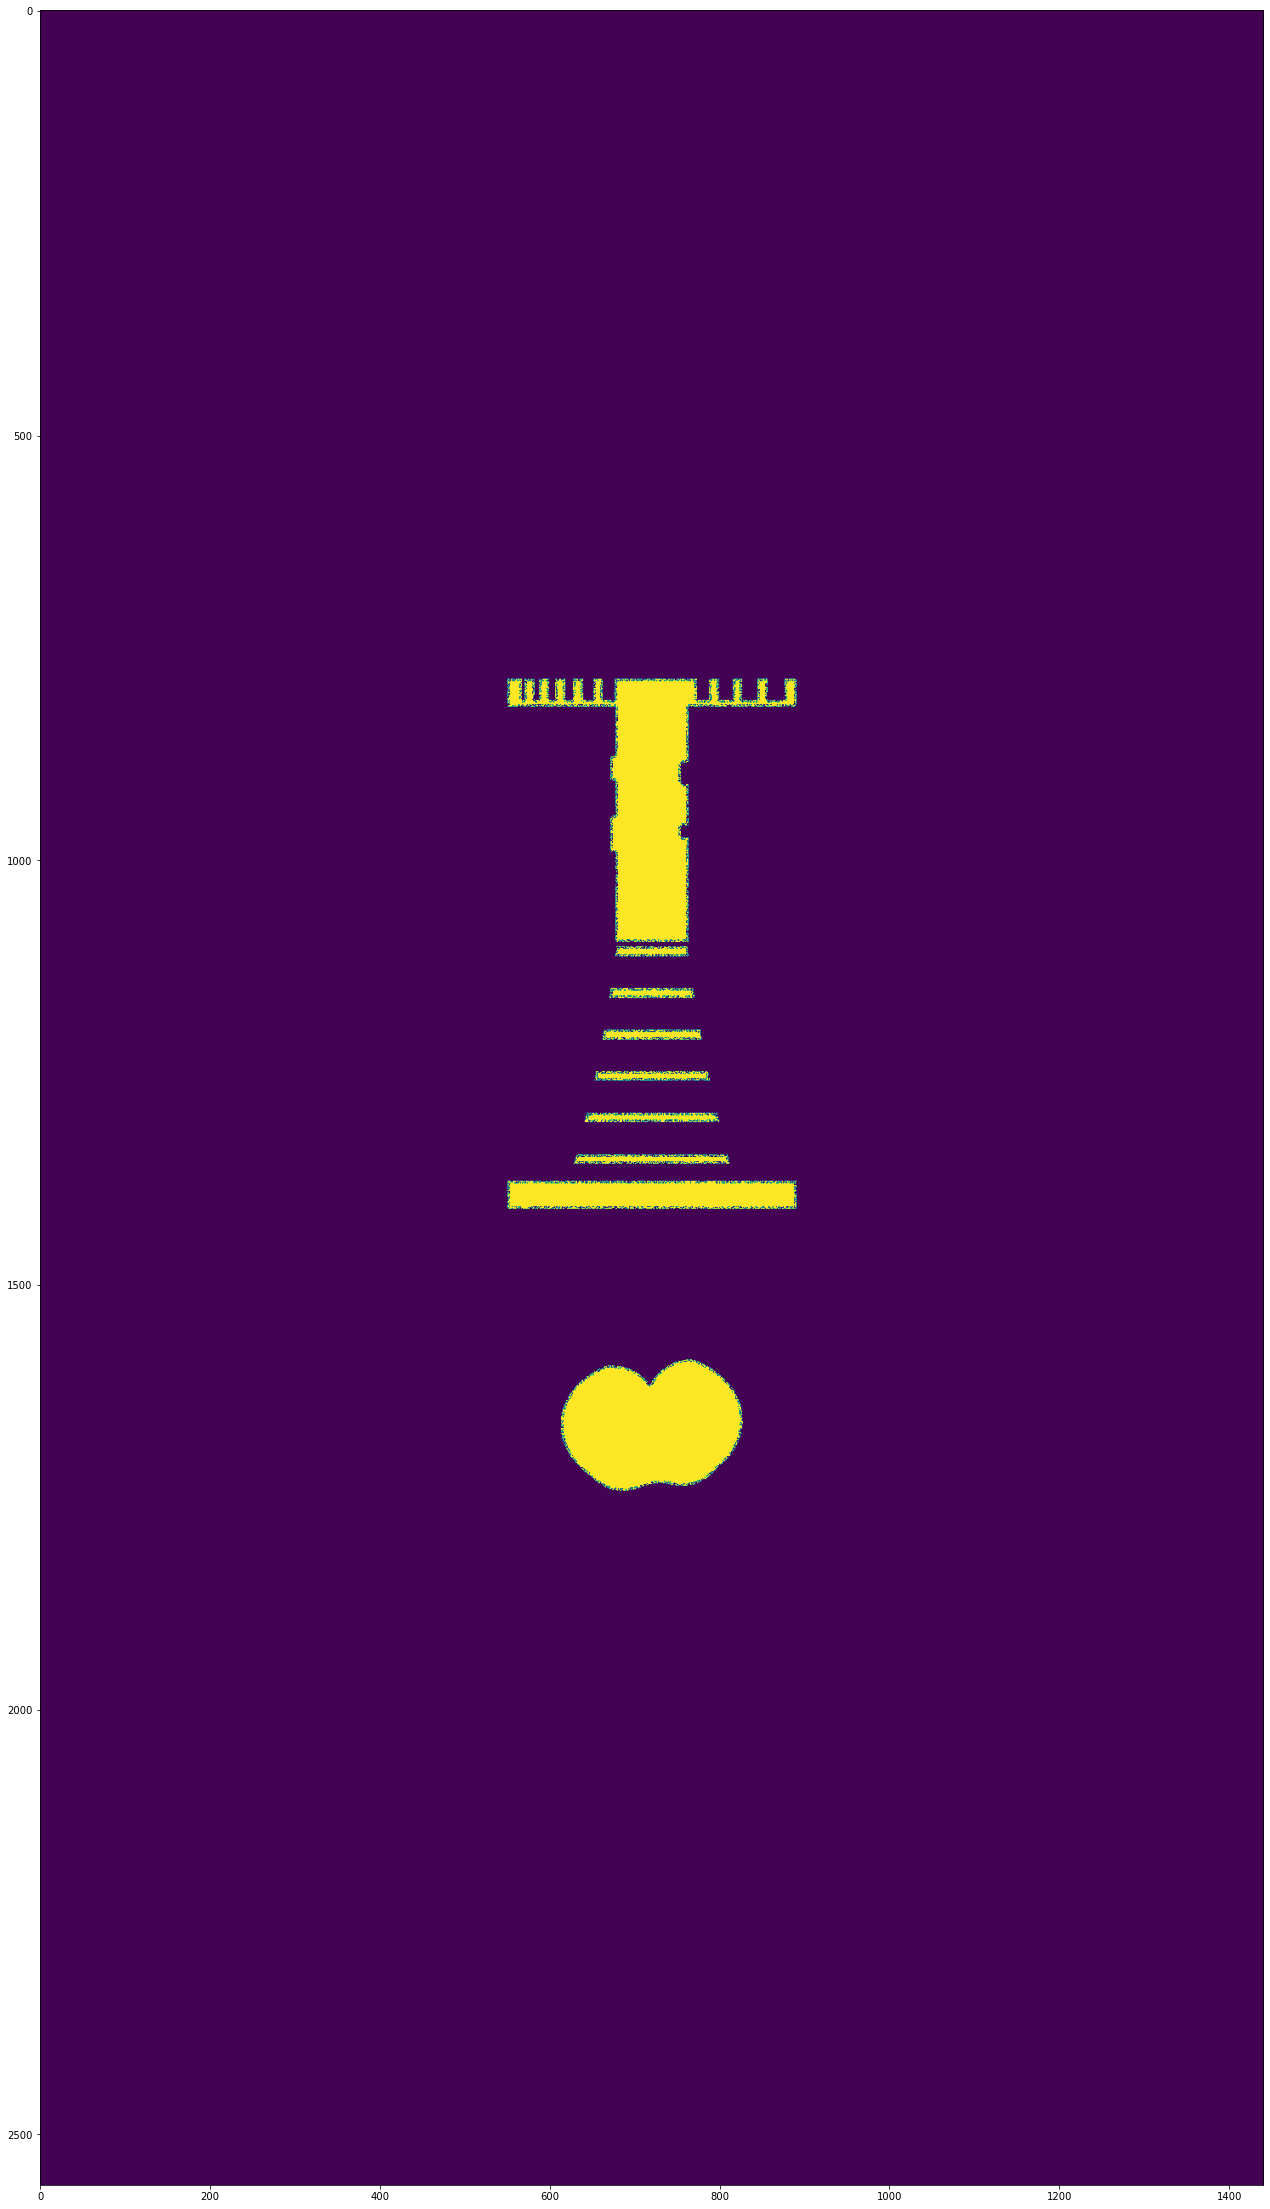

In [176]:
def mess_up_edges(img, new, dept=20, mean=100, sd=100):
    contours, _ = cv.findContours(img, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
    new = cv.drawContours(new, contours, -1, 255, 2*dept)
    # make some noise
    gaussian_noise = np.zeros(img.shape,dtype=np.uint8)
    cv.randn(gaussian_noise, mean, sd)
    # add nose to the contours
    new = new * gaussian_noise
    # add original image
    new = new + img
    # drop middle values (junk)
    new[new < 122] = 0
    new[new >= 122] = 255
    # remove noise from where was not any layer 
    return new - cv.bitwise_not(img)

# drop junk
img[img > 0] = 255
new = np.full(img.shape, 0, np.uint8)
imshow(mess_up_edges(img, new, 2))

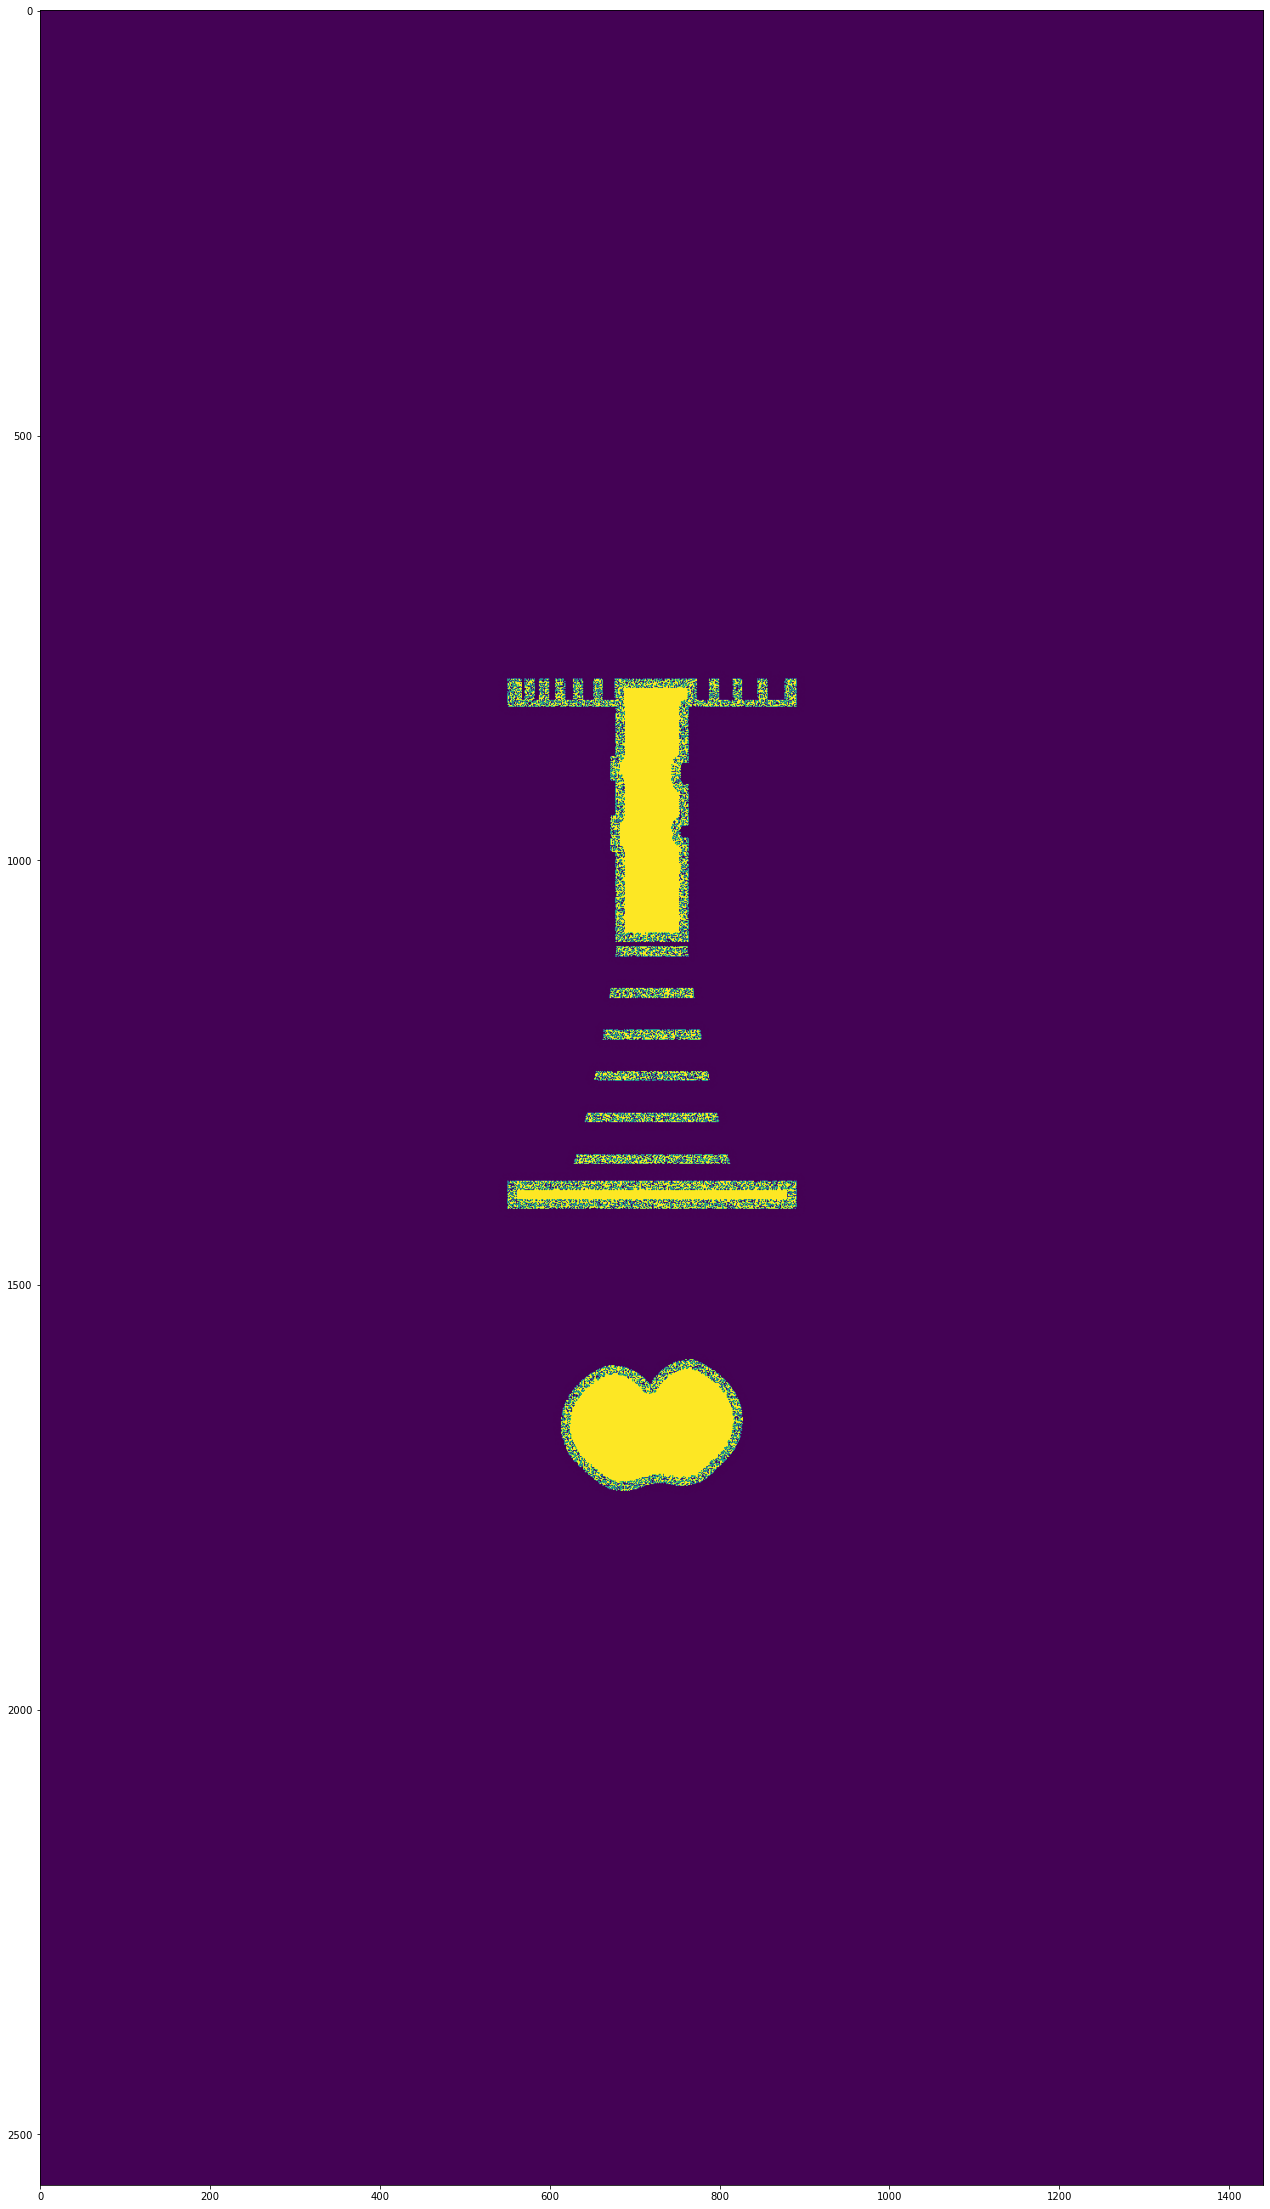

In [165]:
i=mess_up_edges(img, new, 10)
imshow(i-cv.bitwise_not(img) )

### show original

In [130]:
cloud = make_shitty_point_cloud(images)
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(cloud)
pcd.estimate_normals()
o3d.visualization.draw_geometries([pcd])